In [1]:
# Imagine that, for each of some collection of data science–related buzzwords, you have two numbers between
# 0 and 100—the first representing how frequently it appears in job postings, the second how frequently 
# it appears on resumes:

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

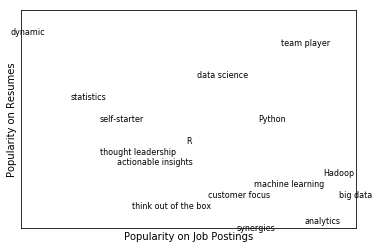

In [3]:
# A more interesting approach might be to scatter them so that horizontal position indicates posting popularity 
# and vertical position indicates resume popularity, which produces a visualization that conveys a few insights

from matplotlib import pyplot as plt

def text_size(total):
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
             ha='center', va='center',
             size=text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# n-gram Models
# The DataSciencester VP of Search Engine Marketing wants to create thousands of web pages about data science 
# so that your site will rank higher in search results for data science–related terms.

# To do this, we’ll need some way of modeling language. One approach is to start with a corpus of documents 
# and learn a statistical model of language. In our case, we’ll start with Mike Loukides’s essay 
# “What is data science?” As in Chapter 9, we’ll use requests and BeautifulSoup to retrieve the data. 


In [5]:
# There are a couple of issues worth calling attention to. The first is that the apostrophes in the text are 
# actually the Unicode character u"\u2019". We’ll create a helper function to replace them with normal apostrophes

def fix_unicode(text):
    return text.replace(u"\u2019", "'")

In [6]:
# The second issue is that once we get the text of the web page, we’ll want to split it into a sequence of words 
# and periods (so that we can tell where sentences end). We can do this using re.findall()

from bs4 import BeautifulSoup
import requests

url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "entry-content")   # find entry-content div
regex = r"[\w']+|[\.]"                        # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

TypeError: 'NoneType' object is not callable

In [7]:
from collections import defaultdict

bigrams = zip(document, document[1:])
transitions = defaultdict(list)
for prev, current in bigrams:
    transitions[prev].append(current)

In [8]:
# Now we’re ready to generate sentences:

def generate_using_bigrams():
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

In [9]:
# We can make the sentences less gibberishy by looking at trigrams, triplets of consecutive words. 
# (More generally, you might look at n-grams consisting of n consecutive words, but three will be plenty for us.) 
# Now the transitions will depend on the previous two words:

trigrams = zip(document, document[1:], document[2:])
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in trigrams:

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

In [10]:
# Notice that now we have to track the starting words separately. We can generate sentences in pretty much the same 
# way:

def generate_using_trigrams():
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

In [11]:
# Grammars 

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

# “So, for example, "_S" is the “sentence” rule, which produces a "_NP" (“noun phrase”) rule followed by a "_VP" 
# (“verb phrase”) rule. The verb phrase rule can produce either the "_V" (“verb”) rule, or the verb rule followed 
# by the noun phrase rule.

In [12]:
# How do we generate sentences from this grammar? We’ll start with a list containing the sentence rule ["_S"]. 
# And then we’ll repeatedly expand each rule by replacing it with a randomly chosen one of its productions. 
# We stop when we have a list consisting solely of terminals

['_S']
['_NP','_VP']
['_N','_VP']
['Python','_VP']
['Python','_V','_NP']
['Python','trains','_NP']
['Python','trains','_A','_NP','_P','_A','_N']
['Python','trains','logistic','_NP','_P','_A','_N']
['Python','trains','logistic','_N','_P','_A','_N']
['Python','trains','logistic','data science','_P','_A','_N']
['Python','trains','logistic','data science','about','_A', '_N']
['Python','trains','logistic','data science','about','logistic','_N']
['Python','trains','logistic','data science','about','logistic','Python']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', 'Python']

In [13]:
# How do we implement this? Well, to start, we’ll create a simple helper function to identify terminals:

def is_terminal(token):
    return token[0] != "_"

In [14]:
# Next we need to write a function to turn a list of tokens into a sentence.

def expand(grammar, tokens):
    for i, token in enumerate(tokens):

        # skip over terminals
        if is_terminal(token): continue

        # if we get here, we found a non-terminal token
        # so we need to choose a replacement at random
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # now call expand on the new list of tokens
        return expand(grammar, tokens)

    # if we get here we had all terminals and are done
    return tokens

In [15]:
# And now we can start generating sentences:

def generate_sentence(grammar):
    return expand(grammar, ["_S"])

In [16]:
# An Aside: Gibbs Sampling

# Gibbs sampling is a technique for generating samples from multidimensional distributions when we only know
# some of the conditional distributions.

In [17]:
# “For example, imagine rolling two dice. Let x be the value of the first die and y be the sum of the dice, 
# and imagine you wanted to generate lots of (x, y) pairs. In this case it’s easy to generate the samples directly:

def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

In [18]:
# But imagine that you only knew the conditional distributions. The distribution of y conditional on x is easy—if 
# you know the value of x, y is equally likely to be x + 1, x + 2, x + 3, x + 4, x + 5, or x + 6:”

def random_y_given_x(x):
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

In [19]:
# If you know that y is 2, then necessarily x is 1 (since the only way two dice can sum to 2 is if both
# of them are 1). If you know y is 3, then x is equally likely to be 1 or 2. Similarly, if y is 11, then 
# x has to be either 5 or 6

def random_x_given_y(y):
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [20]:
# The way Gibbs sampling works is that we start with any (valid) value for x and y and then repeatedly 
# alternate replacing x with a random value picked conditional on y and replacing y with a random value 
# picked conditional on x. After a number of iterations, the resulting values of x and y will represent 
# a sample from the unconditional joint distribution:

def gibbs_sample(num_iters=100):
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [21]:
# You can check that this gives similar results to the direct sample:

def compare_distributions(num_samples=1000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [22]:
# Topic Modeling

# A more sophisticated approach to understanding our users’ interests might try to identify the topics that 
# underlie those interests. A technique called Latent Dirichlet Analysis (LDA) is commonly used to identify 
# common topics in a set of documents. We’ll apply it to documents that consist of each user’s interests.

# There is a random variable that assigns each topic an associated probability distribution over words. 
# You should think of this distribution as the probability of seeing word w given topic k.
# There is another random variable that assigns each document a probability distribution over topics. 
# You should think of this distribution as the mixture of topics in document d.
# Each word in a document was generated by first randomly picking a topic (from the document’s distribution 
# of topics) and then randomly picking a word (from the topic’s distribution of words).

In [23]:
# To start with, we’ll need a function to randomly choose an index based on an arbitrary set of weights:

def sample_from(weights):
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

In [24]:
# “For instance, if you give it weights [1, 1, 3] then one-fifth of the time it will return 0, one-fifth of 
# the time it will return 1, and three-fifths of the time it will return 2.
# Our documents are our users’ interests, which look like:

documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [26]:
# In order to calculate the sampling weights, we’ll need to keep track of several counts. Let’s first create
# the data structures for them.

# How many times each topic is assigned to each document:

# a list of Counters, one for each document

from collections import Counter
document_topic_counts = [Counter() for _ in documents]

In [28]:
# How many times each word is assigned to each topic:

# a list of Counters, one for each topic

K=4 #topics

topic_word_counts = [Counter() for _ in range(K)]

In [29]:
# The total number of words assigned to each topic:

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

In [30]:
# The total number of words contained in each document:

# a list of numbers, one for each document
document_lengths = map(len, documents)

In [31]:
# The number of distinct words:

distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

In [32]:
# And the number of documents:

D = len(documents)

In [33]:
# “For example, once we populate these, we can find, for example, the number of words in documents[3] 
# associated with topic 1 as:

document_topic_counts[3][1]

0

In [34]:
# “And we can find the number of times nlp is associated with topic 2 as:

topic_word_counts[2]["nlp"]

0

In [35]:
# Now we’re ready to define our conditional probability functions. Each has a smoothing term that ensures every
# topic has a nonzero chance of being chosen in any document and that every word has a nonzero chance of being 
# chosen for any topic

def p_topic_given_document(topic, d, alpha=0.1):
    """the fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)"""

    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word, topic, beta=0.1):
    """the fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)"""

    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

In [36]:
# We’ll use these to create the weights for updating topics:

def topic_weight(d, word, k):
    """given a document and a word in that document,
    return the weight for the kth topic"""

    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

In [38]:
# “We start by assigning every word to a random topic, and populating our counters appropriately:

import random
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [39]:
for iter in range(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

In [40]:
# “What are the topics? They’re just numbers 0, 1, 2, and 3. If we want names for them we have to do that ourselves.
# Let’s look at the five most heavily weighted words for each

for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0: print k, word, count

0 Java 3
0 Big Data 3
0 Hadoop 2
0 deep learning 2
0 artificial intelligence 2
0 C++ 2
0 neural networks 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Haskell 1
1 R 4
1 statistics 3
1 Python 3
1 probability 2
1 pandas 2
1 statsmodels 2
1 mathematics 1
1 numpy 1
1 theory 1
1 scipy 1
2 HBase 3
2 Postgres 2
2 MongoDB 2
2 Cassandra 2
2 NoSQL 1
2 MySQL 1
2 Spark 1
3 regression 3
3 libsvm 2
3 scikit-learn 2
3 machine learning 2
3 neural networks 1
3 probability 1
3 Mahout 1
3 Python 1
3 decision trees 1
3 databases 1
3 support vector machines 1


In [41]:
# Based on these I’d probably assign topic names:
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

In [42]:
# at which point we can see how the model assigns topics to each user’s interests:

for document, topic_counts in zip(documents, document_topic_counts):
    print document
    for topic, count in topic_counts.most_common():
        if count > 0:
            print topic_names[topic], count,
    print

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 4 databases 3
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
databases 5
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 5 machine learning 1
['R', 'Python', 'statistics', 'regression', 'probability']
Python and statistics 4 machine learning 1
['machine learning', 'regression', 'decision trees', 'libsvm']
machine learning 4
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
Big Data and programming languages 4 Python and statistics 1 machine learning 1
['statistics', 'probability', 'mathematics', 'theory']
Python and statistics 4
['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
machine learning 4
['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Big Data and programming languages 4
['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big Data and programming languages 4
['statistic